# Bullet-Time Effect

If you are running on Colab,
* Go to runtime -> change runtime type -> select "GPU" as the hardware accelerator. 

## Having Fun with Optical Flow

### ARFlow

Download the code for ARFlow from this link and install the requirements as recommended: https://github.com/lliuz/ARFlow

Make sure that you can run the inference.py without a problem before the next part.

If you could not install ARFlow on your local machine, you can follow these steps either on Colab or on your own machine to make it work:

Download the repository:

In [ ]:
# !wget https://github.com/lliuz/ARFlow/archive/master.zip

--2023-06-02 12:27:12--  https://github.com/lliuz/ARFlow/archive/master.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/lliuz/ARFlow/zip/refs/heads/master [following]
--2023-06-02 12:27:12--  https://codeload.github.com/lliuz/ARFlow/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ]  75,68M  5,67MB/s    in 14s     

2023-06-02 12:27:27 (5,39 MB/s) - ‘master.zip’ saved [79359531]



In [ ]:
# ! cd /content/drive/MyDrive/

In [ ]:
# !ls

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir(r'/content/drive/MyDrive/bullet-time/ARFlow-master/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip the repository:

In [ ]:
# !unzip master.zip

Navigate to the repository:

In [ ]:
# !ls

ARFlow-master  bullet-time.ipynb  master.zip


In [ ]:
# !cd ARFlow-master/

From the menu on the left, open `models/pwclite.py` file, comment the 6th line and uncomment the 7th line.
Then, **if you are using Colab you should not run the next cell**. but if you are on your local machine, install the requirements:

In [ ]:
!pip3 install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


Now you should be able to run the following:

In [ ]:
#! pip install Pillow==6.2.2


/content/drive/MyDrive/bullet-time


/content/drive/MyDrive/bullet-time/ARFlow-master/inference.py:62: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = [imageio.imread(img).astype(np.float32) for img in args.img_list]


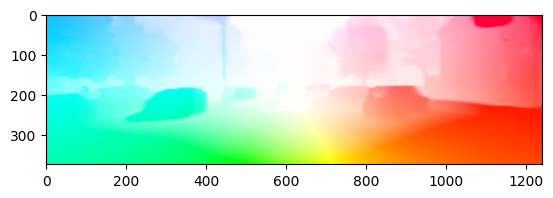

<Figure size 640x480 with 0 Axes>

In [ ]:
%run inference.py -m checkpoints/KITTI15/pwclite_ar.tar -s 384 640  -i examples/img1.png examples/img2.png

### Bullet Time Effect

In this question, you will estimate optical flow using ARFlow (or you can use some other flow method if you cannot make it work) and then use it to interpolate between two images. 

First, calculate the optical flow between two images, e.g. provided KITTI images in the example folder, using the ARFlow as illustrated by the example in inference.py. 
Then, synthesize 10 novel frames between the two images using linear interpolation. 

**Hint:** First, compute the flow and then divide it by the number of frames. Then, at each step, warp the image incrementally to obtain images in between. You can use OpenCV's `remap()` function for warping or have a look at the `flow_warp` in utils/warp_utils.py file of the ARFlow.

* Where does the interpolation work well and where does it fail? 
* Please also hand-in your interpolated images or create a small movie.


In [ ]:
!pwd

/home/moayed/Desktop/hw3/bullet-time/ARFlow-master


In [ ]:
from PIL import Image 

img1 = Image.open('examples/img1.png')
img2 = Image.open('examples/img2.png')
display(img1)
display(img2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# !ls
import numpy as np
import imageio
import matplotlib.pyplot as plt
import torch
from inference import TestHelper
from utils.flow_utils import flow_to_image, resize_flow
from utils.warp_utils import flow_warp

In [ ]:
import numpy as np 
# getting these from the inference.py code 
img_list = ['examples/img1.png', 'examples/img2.png']

cfg = {
    'model': {
        'upsample': True,
        'n_frames': len(img_list),
        'reduce_dense': True
    },
    'pretrained_model': 'checkpoints/KITTI15/pwclite_ar.tar',
    'test_shape': [384, 640],
}

ts = TestHelper(cfg)
imgs = [imageio.imread(img).astype(np.float32) for img in img_list]
h, w = imgs[0].shape[:2]

<ipython-input-21-f90649257ac4>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = [imageio.imread(img).astype(np.float32) for img in img_list]


In [ ]:
flow = ts.run(imgs)['flows_fw'][0]

flow = resize_flow(flow, (h, w))

flow_np = flow[0].detach().cpu().numpy().transpose([1, 2, 0])

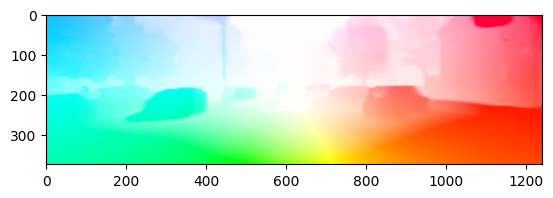

In [ ]:
flow_img = flow_to_image(flow_np)
plt.imshow(flow_img)
plt.show()

In [ ]:
num_frames = 10

flow_step = -flow / num_frames

images = [torch.from_numpy(np.array(imgs[0])).permute(2, 0, 1).unsqueeze(0).cuda()]

current_image = imgs[0]

for i in range(num_frames - 1):
    images.append(flow_warp(images[-1], flow_step))

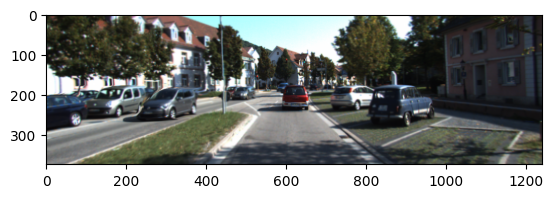

In [ ]:
plt.imshow(images[9][0].permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8))
plt.show()

In [ ]:
imgs_out = [img[0].permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8) for img in images]


In [ ]:
for i, img in enumerate(imgs_out):
  plt.imshow(img)
  plt.show()
  img = Image.fromarray(img, "RGB")
  img.save(f'{i}_result.png')

Output hidden; open in https://colab.research.google.com to view.

## Where does the interpolation work well and where does it fail ?
It works well every where but around the edges of the moving objects.

### Multi-frame Bullet Time Sequence (Optional)

If you had fun with the previous question, you might want to extend this effect to several frames as in the original Matrix movie! 

Use consecutive images from last week's sequence or capture several images along a smooth camera trajectory and smoothly vary the pose of the objects in between. 

Between each two adjacent frames, interpolate an additional 10 to 100 frames and concatenate all images to one long slow motion video sequence.